In [1]:
from pathlib import Path

# data manipulation libraries
import numpy as np
import xarray as xr
import fsspec

In [2]:
import warnings
warnings.filterwarnings("ignore")

FIG_DIR  = Path('figures')
DATA_DIR = Path('data')

In [3]:
# plotting libraries

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

sns.set_style("whitegrid")

from holoviews.operation import contours
import geoviews as gv
import geoviews.feature as gf

# Geoview Plot Options
# gv.extension('matplotlib')
gv.output(size=200)

from IPython.core.display import HTML

# Center matplotlib's figures
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Funciones Útiles

In [4]:
def basic_stats(da, var_name, save=False):
    ind_var = ['time', 'lat', 'lon']
    
    
    df = da.max(dim=ind_var).to_dataframe().reset_index()
    df['min_'  + var_name] = da.min(dim=ind_var).values
    df['mean_' + var_name] = da.mean(dim=ind_var).values
    df['std_'  + var_name] = da.std(dim=ind_var).values
    
    df = df.rename({var_name: 'max_' + var_name}, axis=1)
    
    if save:
        path = DATA_DIR / (var_name + '.csv')
        df.to_csv(path)
    
    return df

def plot_stats(df, var_name, long_name, save=False):
    """
    Plot basic statistics from DataFrame that has levels.
    """
    fig, ax = plt.subplots(figsize=(8,8))
    
    df.plot(x='level', y=['mean_' + var_name, 
                          'max_'  + var_name, 
                          'min_'  + var_name], ax=ax);

    ax.fill_between(df.level, 
                    df['mean_' + var_name] - 2 * df['std_' + var_name], 
                    df['mean_' + var_name] + 2 * df['std_' + var_name],
                    color='b', alpha=0.15);
    
    title = long_name + ' per level'
    ax.set_title(title)

    if save:
        title = title.replace(' ', '_') + '.png'
        try:
            plt.savefig(FIG_DIR / title )
        except Exception as e:
            print(e)
            plt.savefig(title)
            
def faceted_groups_plot(da, groupped_by, title, save=False):
    """
    FacetPlot where each col is a group and each row is a level.
    
    Params:
    -------
    da  (xr.DataArray)   : Groupped DataArray with levels
    groupped_by (string) : Dimension used to group values
    title (string)       : Title for plot
    save  (bool)         : Whether to save the fig, will use the title
    
    Example:
    --------
    >>> anomalies_season = ds.groupby('time.season') - ds.groupby('time.season').mean('time')
    >>>
    >>> levels = [100, 500, 850]
    >>>
    >>> da = anomalies_season.sel(level=levels).groupby('season').mean(dim=['time']).compute()
    >>>
    >>> faceted_groups_plot(da=da, 
    ...                     groupped_by='season',
    ...                     title=f'Seasonal Mean Anomalies, level={levels}')
    ... <plot>
    """

    print(title)
    if 'level' in da.coords:
        p = da.plot.contourf(
             subplot_kws=dict(projection=ccrs.Orthographic(-80, -35), facecolor="gray"), 
             transform=ccrs.PlateCarree(), add_colorbar=False, robust=True,
             col=groupped_by, 
             row='level'
        )
        
    else:
        p = da.plot.contourf(
         subplot_kws=dict(projection=ccrs.Orthographic(-80, -35), facecolor="gray"), 
         transform=ccrs.PlateCarree(), add_colorbar=False, robust=True,
         col=groupped_by, col_wrap=4, 
    )

    axes_iter = p.axes.flat
    
    for ax in axes_iter:
        ax.coastlines()
        ax.gridlines()



    plt.tight_layout()
    plt.draw()

    if save:
        title = title.replace(', ', '_') + '.png'
        
        try:
            plt.savefig(FIG_DIR / title)
        except Exception as e:
            print(e)
            plt.savefig(title)

    plt.show()
    
def cartopy_world_plot(region_da, title, time_sel=0, level_sel=False, center=(-75, -20), extent=None, save=False):
    
    if type(level_sel) is int:
        da = region_da.isel(level=level_sel)
    else:
        da = region_da
        
    plt.figure(figsize=(15,7))
    
    ax = plt.axes(projection=ccrs.Orthographic(*center))
    
    ax.set_title(title)
    
    if extent is not None:
        print('asda')
        ax.set_extent(extent,  crs=ccrs.PlateCarree())
        
    da.isel(time=time_sel).plot.contourf(ax=ax, transform=ccrs.PlateCarree());
    
    ax.set_global(); ax.coastlines();
    plt.show()
    
    if save:
        title = title.replace(', ', '_') + '.png'
        
        try:
            plt.savefig(FIG_DIR / title)
        except Exception as e:
            print(e)
            plt.savefig(title)

    plt.show()
        

def geoview_flat_plot(region_da, var_name, time_sel=0, level_sel=False, wide_chile=True):
    
    if type(level_sel) is int:
        da = region_da.isel(level=level_sel)
    else:
        da = region_da
    
    gv_ds = gv.Dataset(da.isel(time=time_sel))
    plot = gv_ds.to(gv.Image,  ['lon', 'lat'], var_name, 'time').opts(cmap='viridis', 
                                                                  colorbar=True)
    
    extras = []
    if wide_chile:
        easter_island_text = gv.Text(-104.360481, -24.104671, 'Easter Island').opts(color='white')
        easter_island_point = gv.Points([(-109.360481, -27.104671)]).opts(color='red')

        easter = easter_island_point * easter_island_text

        falkland_islands_text = gv.Text(-49.563412, -56.820557, 'Falklands').opts(color='white')
        falkland_islands_point = gv.Points([(-51.563412, -59.820557)]).opts(color='red')

        falkland = falkland_islands_point * falkland_islands_text
        
        extras.append(easter * falkland)
    
    plot = contours(plot, filled=True, overlaid=True)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        final_plot = plot * gf.coastline
        for extra in extras:
            final_plot *= extra
        gv.output(final_plot)

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

# Proyecto

## Motivación

Los impactos del cambio climático son visibles hoy mismo: temperaturas elevadas, sequías, eventos extremos, etc.

Es necesario mejorar las herramientas que existen en la actualidad para poder obtener resilencia y adaptación a estos impactos.

Predicciones Numéricas del Tiempo (NWP)

- Modelos Dinámicos (Complejos, lentos y computacionalmente caros):
    * Dependencia de condiciones iniciales: naturaleza caótica de la atmósfera
    * Ensembles con diferentes condiciones iniciales o parámetros para capturar incertidumbre


- Observaciones in situ e Integración de Datos

- Post-Procesamiento y Evaluación del Modelo

## Dataset

El dataset se compone de los siguientes datos desde 1979 a 2018 por hora:
- Campos 3D:  
    * Geopotencial  
    * Temperatura  
    * Humedad  
    * Viento  
    
    
- Campos 2-D:  
    * Temperatura 2 metros  
    * Viento 10 metros  
    * Cobertura de Nubes  
    * Precipitación  
    
- Constantes:  
    * Máscara tierra-mar  
    * Tipo de suelo  
    * Orografía  
    * Latitud, Longitud  
    

## Objetivo

El problema en cuestión es de regresión y consiste de la predicción de la variable de geopotencial a $500hPa$, temperatura a $850hPa$ y la temperatura a 2 metros.

## Métrica Importante

![MSE con un factor geografico](figures/weighted_mse.png "MSE con un factor")

# Exploración de Datos


In [5]:
ds = xr.open_zarr(fsspec.get_mapper('gcs://weather-bench/region_zarr/'), consolidated=True)
ds

<xarray.Dataset>
Dimensions:    (lat: 12, level: 13, lon: 14, time: 350640)
Coordinates:
  * lat        (lat) float64 -70.31 -64.69 -59.06 ... -19.69 -14.06 -8.438
  * level      (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * lon        (lon) float64 247.5 253.1 258.8 264.4 ... 303.8 309.4 315.0 320.6
  * time       (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    lat2d      (lat, lon) float64 dask.array<chunksize=(12, 14), meta=np.ndarray>
    lon2d      (lat, lon) float64 dask.array<chunksize=(12, 14), meta=np.ndarray>
    lsm        (lat, lon) float32 dask.array<chunksize=(12, 14), meta=np.ndarray>
    orography  (lat, lon) float32 dask.array<chunksize=(12, 14), meta=np.ndarray>
    pv         (time, level, lat, lon) float32 dask.array<chunksize=(43830, 2, 3, 4), meta=np.ndarray>
    q          (time, level, lat, lon) float32 dask.array<chunksize=(43830, 2, 3, 4), meta=np.ndarray>
    r          (time, level, lat, lon) float32 dask.array<chunksize=(43830, 2, 3, 4), meta=np.ndarray>
    slt        (lat, lon) float32 dask.array<chunksize=(12, 14), meta=np.ndarray>
    t          (time, level, lat, lon) float32 dask.array<chunksize=(43830, 2, 3, 4), meta=np.ndarray>
    t2m        (time, lat, lon) float32 dask.array<chunksize=(43830, 2, 4), meta=np.ndarray>
    tcc        (time, lat, lon) float32 dask.array<chunksize=(43830, 2, 4), meta=np.ndarray>
    u10        (time, lat, lon) float32 dask.array<chunksize=(43830, 2, 4), meta=np.ndarray>
    v10        (time, lat, lon) float32 dask.array<chunksize=(43830, 2, 4), meta=np.ndarray>
    vo         (time, level, lat, lon) float32 dask.array<chunksize=(43830, 2, 3, 4), meta=np.ndarray>
    z          (time, level, lat, lon) float32 dask.array<chunksize=(43830, 2, 3, 4), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-03-08 20:51:24 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [6]:
import numpy as np

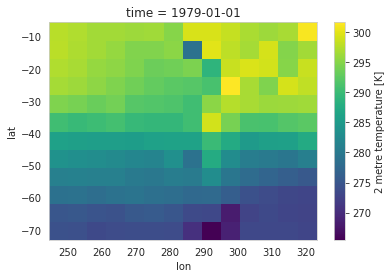

In [7]:
ds.t2m[0].load().plot()

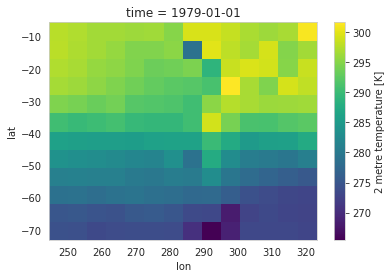

In [8]:
(ds.t2m[0].load()).plot()

In [9]:
ds.t2m[0]

<xarray.DataArray 't2m' (lat: 12, lon: 14)>
dask.array<getitem, shape=(12, 14), dtype=float32, chunksize=(2, 4), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -70.31 -64.69 -59.06 -53.44 ... -19.69 -14.06 -8.438
  * lon      (lon) float64 247.5 253.1 258.8 264.4 ... 303.8 309.4 315.0 320.6
    time     datetime64[ns] 1979-01-01
Attributes:
    long_name:  2 metre temperature
    units:      K

**Recuerdo de latitud - longitud:**

![lat_lon](https://s3.us-east-2.amazonaws.com/journeynorth.org/images/graphics/mclass/Lat_Long.gif "lat_lon")

## Región: Chile + Océano Pacífico

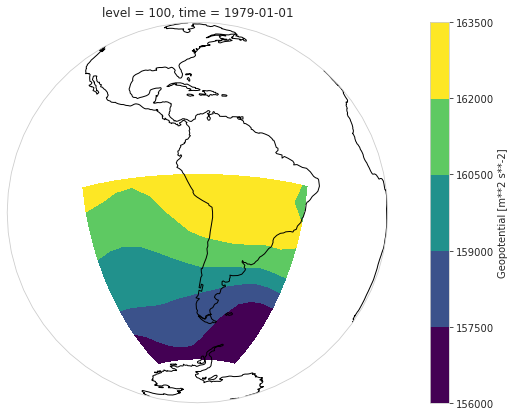

In [10]:
cartopy_world_plot(ds.z, title='', level_sel=1)

In [11]:
# import hvplot.xarray

# ds.z.isel(time=-1).hvplot.quadmesh(x='lon', y='lat', levels=10,
#                                     clabel='Z [m**2/s**-2]', label='Geopotential',
#                                     cmap='viridis')

## Niveles 

- 13 Niveles:
    + 50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000 hPa
    
    
- La presión al nivel del mar es de aproximadamente 1000 hPa y **disminuye** aproximadamente de manera exponencial con la altura. 850 hPa está a unos 1,5 km de altura. 500 hPa está a unos 5,5 km de altura. Si la presión de la superficie es menor que un nivel de presión dado, por ejemplo a grandes altitudes, los valores del nivel de presión se interpolan.


- Los niveles de presión seleccionados contienen los siete niveles de presión que se utilizan comúnmente para la salida en 3D por los modelos climáticos en el Proyecto de Intercomparación de Modelos Acoplados Fase 6 del CMIP6



In [12]:
df_means = global_mean(ds.resample(time='1M').mean())[['t2m', 't', 'z']].to_dataframe().reset_index()

df_means[['t2m', 't', 'z']] = (df_means[['t2m', 't', 'z']] - df_means[['t2m', 't', 'z']].mean()) / df_means[['t2m', 't', 'z']].std()

In [13]:
df_means 

time       t2m         t         z
0   1979-01-31  1.258849  1.485960  1.370763
1   1979-02-28  1.418261  1.442289  1.454890
2   1979-03-31  1.093087  1.037094  1.223281
3   1979-04-30  0.387880  0.426572  0.120489
4   1979-05-31 -0.292581 -0.187943 -0.296176
..         ...       ...       ...       ...
475 2018-08-31 -1.304931 -1.303424 -1.305586
476 2018-09-30 -0.887476 -1.111602 -1.191501
477 2018-10-31 -0.416682 -0.544831 -0.267949
478 2018-11-30  0.228847  0.540241  0.117858
479 2018-12-31  0.854461  0.913033  0.875274

[480 rows x 4 columns]

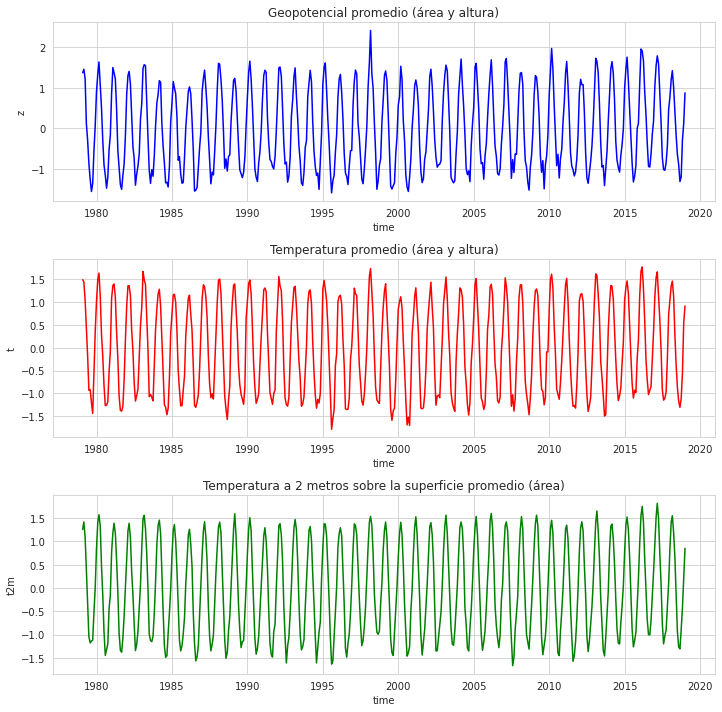

In [14]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,10))

# f.suptitle('Comportamiento promedio de distintas variables a lo largo del tiempo')

sns.lineplot(data=df_means, x='time', y='z', color="b", ax=ax[0])
ax[0].set_title('Geopotencial promedio (área y altura)')

sns.lineplot(data=df_means, x='time', y='t', color="r", ax=ax[1])
ax[1].set_title('Temperatura promedio (área y altura)')

sns.lineplot(data=df_means, x='time', y='t2m',  color="g", ax=ax[2])
ax[2].set_title('Temperatura a 2 metros sobre la superficie promedio (área)')

plt.tight_layout()

plt.show()

## Exploración Variables Esenciales

- Geopotencial, $Z$
- Temperatura, $T$
- Temperatura a 2 metros, $T2m$

### 1. Geopotencial x Niveles

El geopotencial es el potencial del campo gravitatorio de la Tierra. Esencial para los Modelos de Circulación General (ecuaciones dinámicas del clima).

Por comodidad se suele definir como el negativo de la energía potencial, de modo que el vector de gravedad se obtiene como el gradiente de este potencial, sin la negación. 


Recuerdo de unidades:

- Energia potencial: $m · g · h$ = $m · m/s^2  · 1 = m^2/s^2$


In [15]:
z = ds['z']
z

<xarray.DataArray 'z' (time: 350640, level: 13, lat: 12, lon: 14)>
dask.array<zarr, shape=(350640, 13, 12, 14), dtype=float32, chunksize=(43830, 2, 3, 4), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -70.31 -64.69 -59.06 -53.44 ... -19.69 -14.06 -8.438
  * level    (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * lon      (lon) float64 247.5 253.1 258.8 264.4 ... 303.8 309.4 315.0 320.6
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Attributes:
    long_name:      Geopotential
    standard_name:  geopotential
    units:          m**2 s**-2

#### Rango de $Z$ y distribución

In [16]:
df = basic_stats(z, 'z', save=True)
df.head()

level          max_z          min_z         mean_z        std_z
0     50  205326.500000  177141.687500  199568.484375  4767.900391
1    100  164440.906250  139401.343750  158055.375000  4688.270020
2    150  141369.234375  116642.070312  133653.296875  5084.731445
3    200  123483.093750  100085.640625  115937.656250  5133.643555
4    250  108791.843750   86887.054688  101879.328125  4897.586914

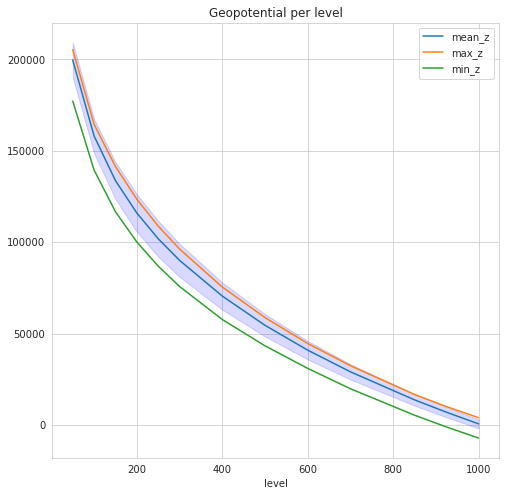

In [17]:
plot_stats(df, 'z', long_name=z.long_name, save=True)

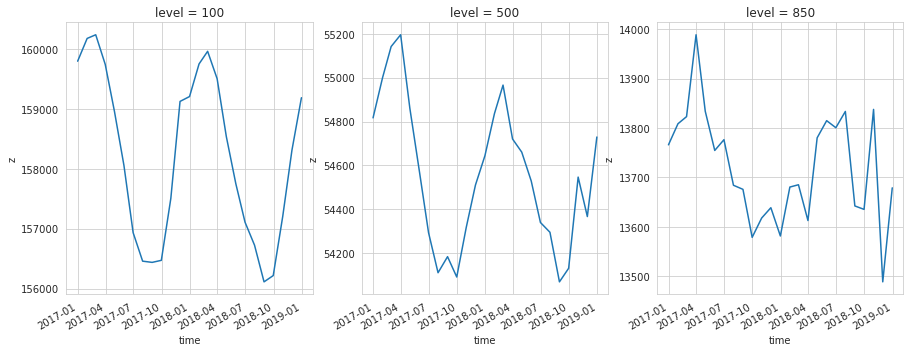

In [18]:
levels = [100, 500, 850]

da = z.mean(['lat', 'lon']).resample({'time': 'M'}).mean().isel(time=slice(-25, None))

f, axs = plt.subplots(ncols=3, figsize=(15,5))

for level, ax in zip(levels, axs.flatten()):
    da.sel(level=level).plot(ax=ax)

plt.show()

#### Daily, Monthly, Seasonal Means: Climatologies

In [19]:
z_season_mean = z.groupby('time.season').mean('time')
z_season_std  = z.groupby('time.season').std('time')

z_month_mean = z.groupby('time.month').mean('time')
z_month_std  = z.groupby('time.month').std('time')

In [20]:
anomalies_month = z.groupby('time.month') - z_month_mean
anomalies_month

<xarray.DataArray 'z' (time: 350640, level: 13, lat: 12, lon: 14)>
dask.array<getitem, shape=(350640, 13, 12, 14), dtype=float32, chunksize=(744, 2, 3, 4), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 247.5 253.1 258.8 264.4 ... 303.8 309.4 315.0 320.6
  * lat      (lat) float64 -70.31 -64.69 -59.06 -53.44 ... -19.69 -14.06 -8.438
  * level    (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12

Monthly Mean Anomalies, level=[100, 500, 850]


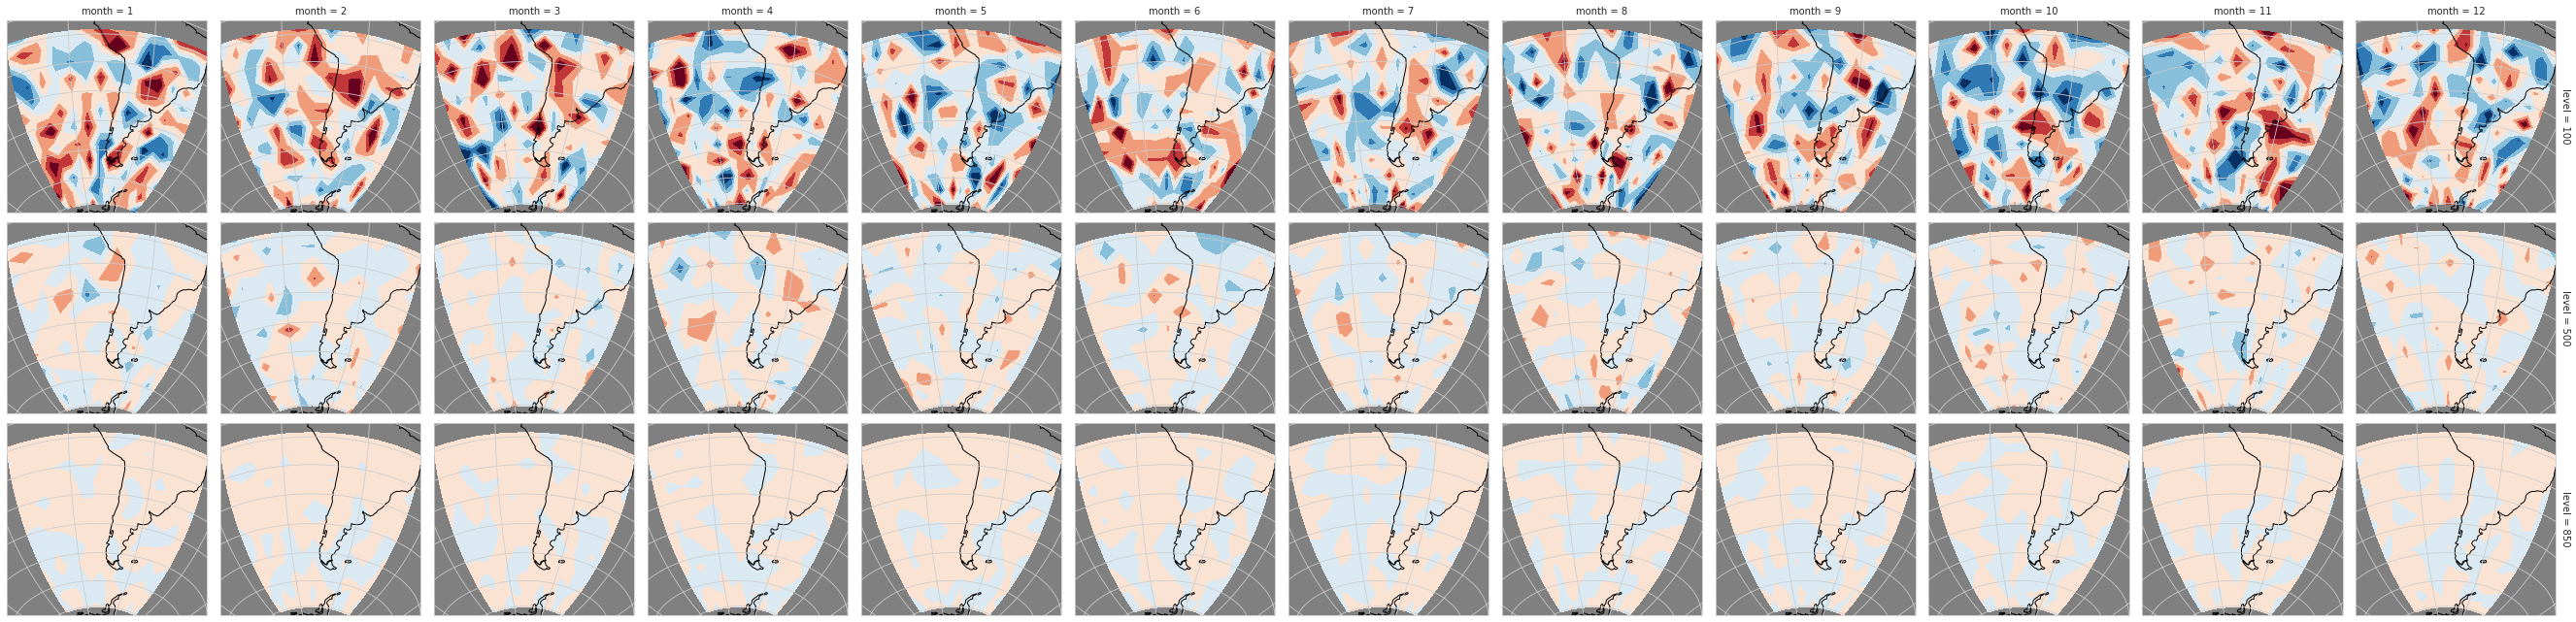

In [21]:
levels = [100, 500, 850]

da = anomalies_month.sel(level=levels).groupby('month').mean(dim=['time']).compute()

title = f'Monthly Mean Anomalies, level={levels}'

faceted_groups_plot(da, 'month', title, save=True)

In [22]:
anomalies_season = z.groupby('time.season') - z_season_mean
anomalies_season

<xarray.DataArray 'z' (time: 350640, level: 13, lat: 12, lon: 14)>
dask.array<getitem, shape=(350640, 13, 12, 14), dtype=float32, chunksize=(2208, 2, 3, 4), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 247.5 253.1 258.8 264.4 ... 303.8 309.4 315.0 320.6
  * lat      (lat) float64 -70.31 -64.69 -59.06 -53.44 ... -19.69 -14.06 -8.438
  * level    (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
    season   (time) <U3 'DJF' 'DJF' 'DJF' 'DJF' ... 'DJF' 'DJF' 'DJF' 'DJF'

Seasonal Mean Anomalies for geopotential, level=[100, 500, 850]


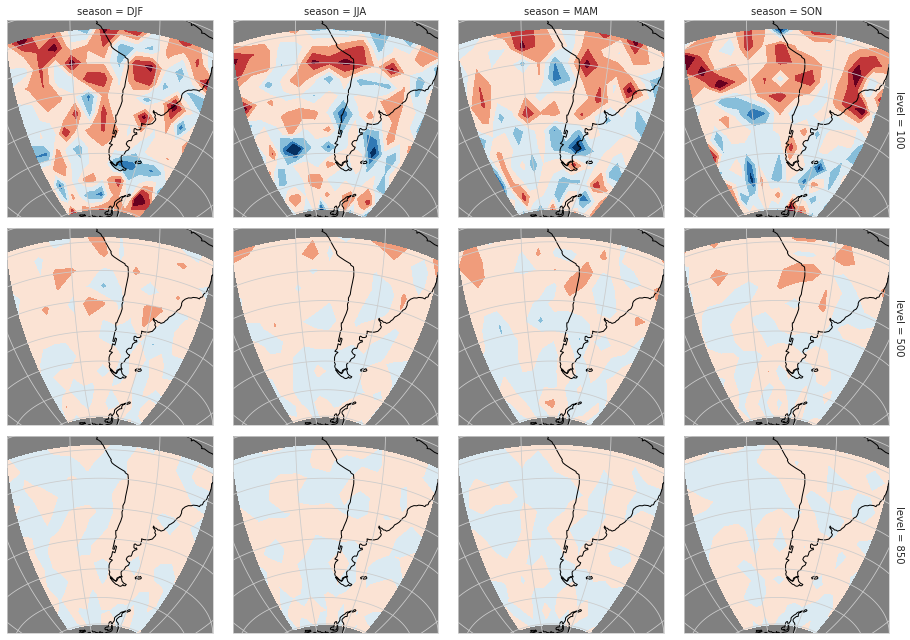

In [23]:
levels = [100, 500, 850]

da = anomalies_season.sel(level=levels).groupby('season').mean(dim=['time']).compute()

title = f'Seasonal Mean Anomalies for geopotential, level={levels}'

faceted_groups_plot(da, 'season', title, save=True)

### 2. Temperatura x Niveles

In [24]:
t = ds['t']
t

<xarray.DataArray 't' (time: 350640, level: 13, lat: 12, lon: 14)>
dask.array<zarr, shape=(350640, 13, 12, 14), dtype=float32, chunksize=(43830, 2, 3, 4), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -70.31 -64.69 -59.06 -53.44 ... -19.69 -14.06 -8.438
  * level    (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * lon      (lon) float64 247.5 253.1 258.8 264.4 ... 303.8 309.4 315.0 320.6
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Attributes:
    long_name:      Temperature
    standard_name:  air_temperature
    units:          K

#### Rango de $T$ y distribución

In [25]:
df = basic_stats(t, 't', save=True)
df.head()

level       max_t       min_t      mean_t      std_t
0     50  253.301666  173.987305  211.459824   8.593836
1    100  244.781845  174.301437  207.504852  10.645928
2    150  240.612808  181.117661  212.346542   7.701759
3    200  241.834793  187.687561  216.886658   6.357095
4    250  246.350632  194.098862  222.597672   7.498000

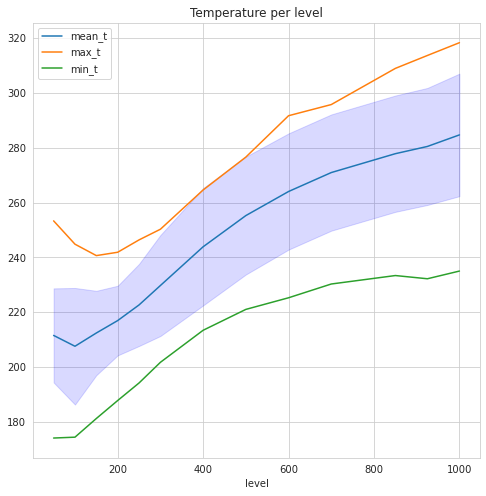

In [26]:
plot_stats(df, 't', long_name=t.long_name, save=True)

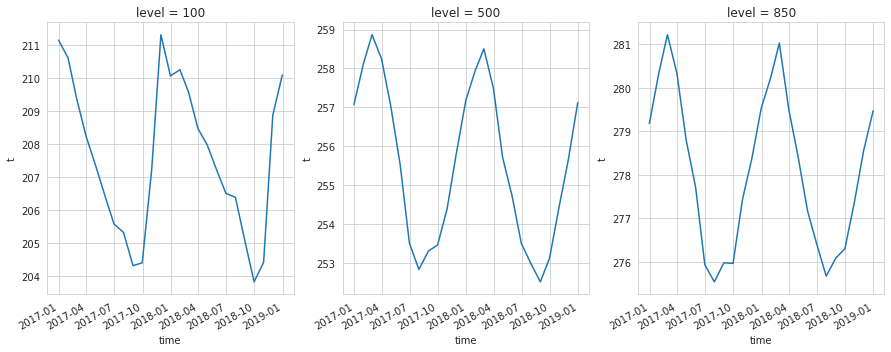

In [27]:
levels = [100, 500, 850]

da = t.mean(['lat', 'lon']).resample({'time': 'M'}).mean().isel(time=slice(-25, None))

f, axs = plt.subplots(ncols=3, figsize=(15,5))

for level, ax in zip(levels, axs.flatten()):
    da.sel(level=level).plot(ax=ax)

plt.show()

#### Daily, Monthly, Seasonal Means

In [28]:
t_season_mean = t.groupby('time.season').mean('time')
t_season_std  = t.groupby('time.season').std('time')

t_month_mean = t.groupby('time.month').mean('time')
t_month_std  = t.groupby('time.month').std('time')

In [29]:
anomalies_month = t.groupby('time.month') - t_month_mean
anomalies_month

<xarray.DataArray 't' (time: 350640, level: 13, lat: 12, lon: 14)>
dask.array<getitem, shape=(350640, 13, 12, 14), dtype=float32, chunksize=(744, 2, 3, 4), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 247.5 253.1 258.8 264.4 ... 303.8 309.4 315.0 320.6
  * lat      (lat) float64 -70.31 -64.69 -59.06 -53.44 ... -19.69 -14.06 -8.438
  * level    (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12

Monthly Mean Anomalies, level=[100, 500, 850]


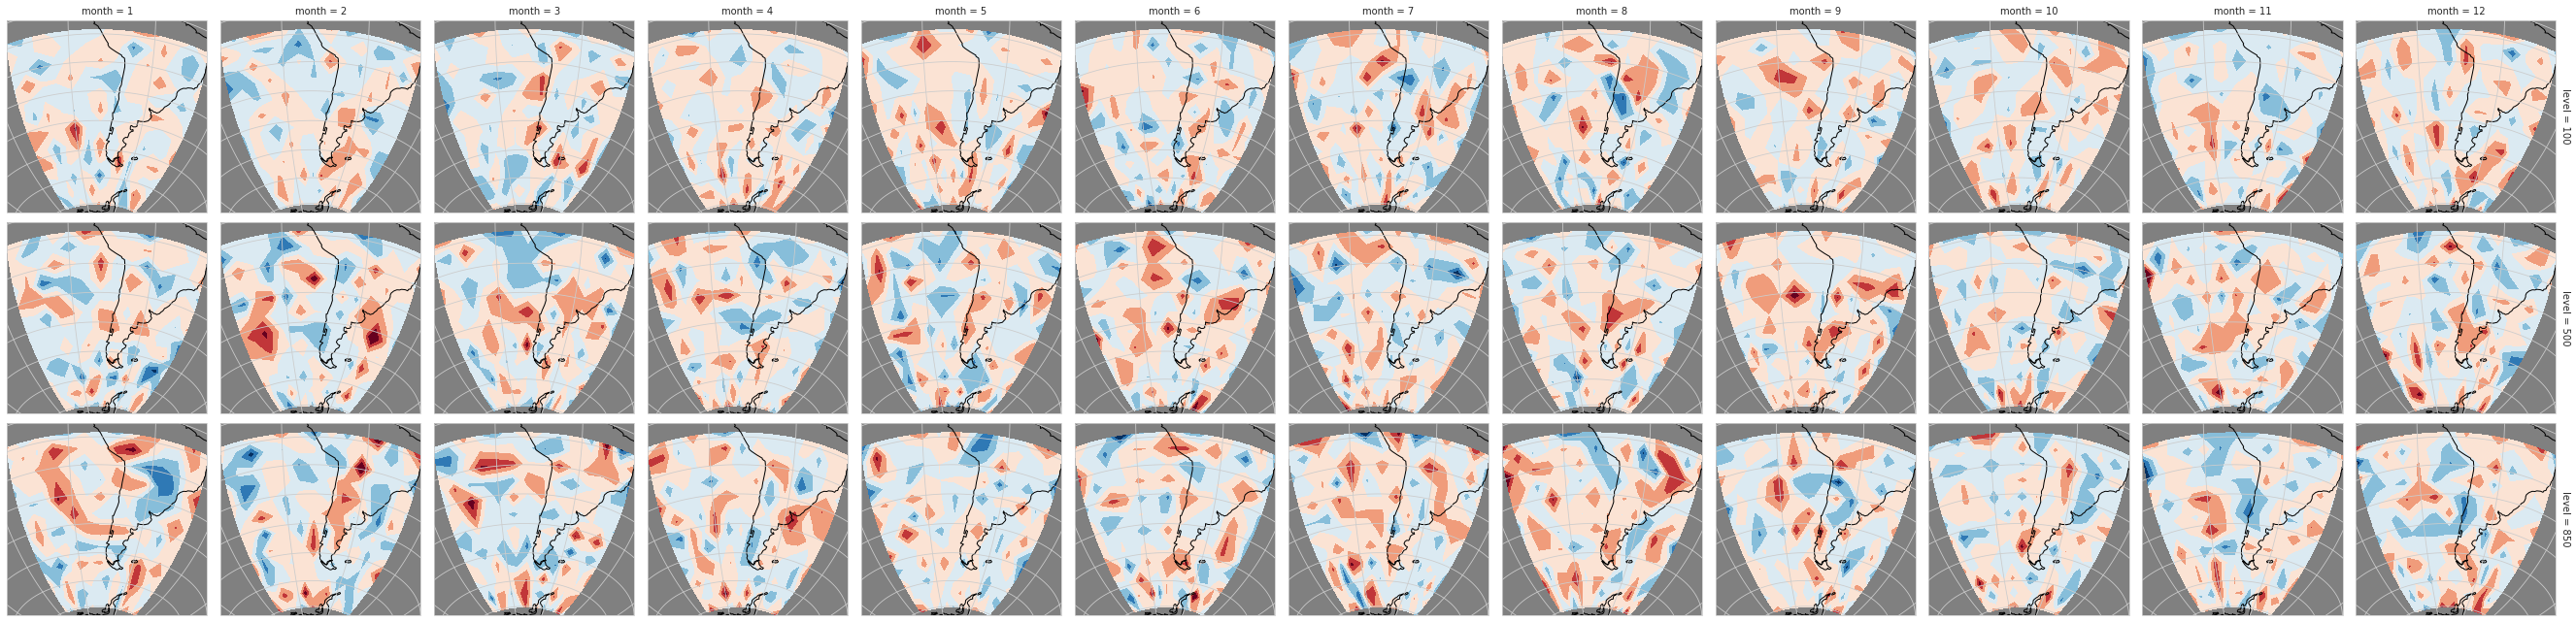

In [30]:
levels = [100, 500, 850]

da = anomalies_month.sel(level=levels).groupby('month').mean(dim=['time']).compute()

title = f'Monthly Mean Anomalies, level={levels}'

faceted_groups_plot(da, 'month', title, save=True)

In [31]:
anomalies_season = t.groupby('time.season') - t_season_mean
anomalies_season

<xarray.DataArray 't' (time: 350640, level: 13, lat: 12, lon: 14)>
dask.array<getitem, shape=(350640, 13, 12, 14), dtype=float32, chunksize=(2208, 2, 3, 4), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 247.5 253.1 258.8 264.4 ... 303.8 309.4 315.0 320.6
  * lat      (lat) float64 -70.31 -64.69 -59.06 -53.44 ... -19.69 -14.06 -8.438
  * level    (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
    season   (time) <U3 'DJF' 'DJF' 'DJF' 'DJF' ... 'DJF' 'DJF' 'DJF' 'DJF'

Seasonal Mean Anomalies for temperature, level=[100, 500, 850]


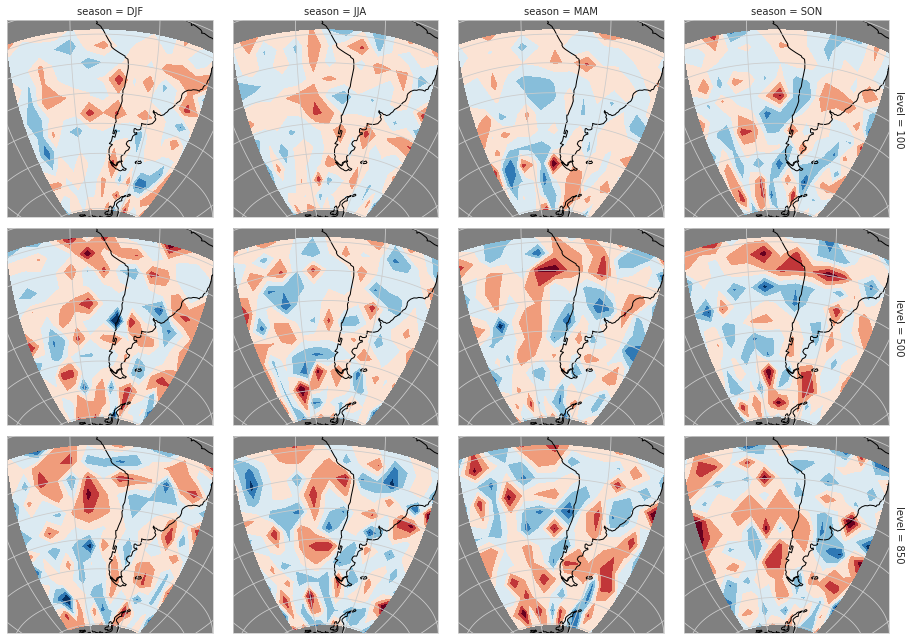

In [32]:
levels = [100, 500, 850]

da = anomalies_season.sel(level=levels).groupby('season').mean(dim=['time']).compute()

title = f'Seasonal Mean Anomalies for temperature, level={levels}'

faceted_groups_plot(da, 'season', title, save=True)

### 3. Temperatura a 2 metros

#### Rango de $T2m$ y distribución

In [33]:
t2m = ds['t2m']
t2m

<xarray.DataArray 't2m' (time: 350640, lat: 12, lon: 14)>
dask.array<zarr, shape=(350640, 12, 14), dtype=float32, chunksize=(43830, 2, 4), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -70.31 -64.69 -59.06 -53.44 ... -19.69 -14.06 -8.438
  * lon      (lon) float64 247.5 253.1 258.8 264.4 ... 303.8 309.4 315.0 320.6
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Attributes:
    long_name:  2 metre temperature
    units:      K

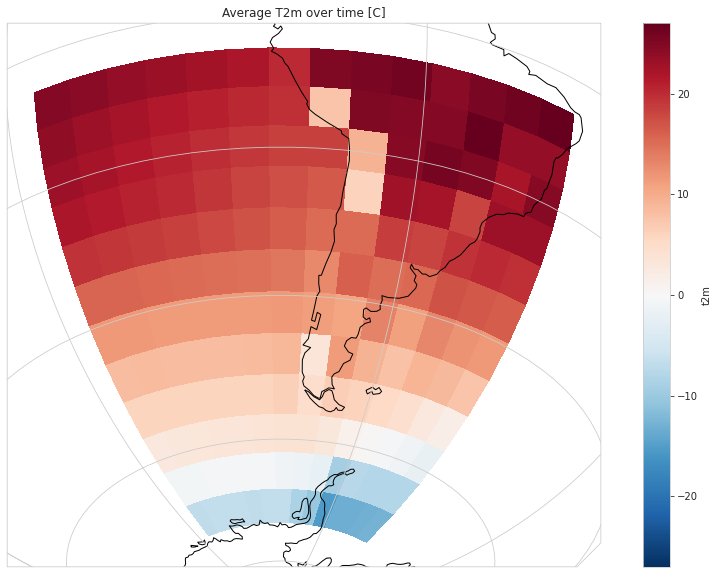

In [34]:
f = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.Orthographic(-80, -35))

p = (t2m.mean(dim='time') - 273.15).plot(ax=ax, transform=ccrs.PlateCarree())

ax.set_title('Average T2m over time [C]')
p.axes.coastlines()
p.axes.gridlines()

if True:
    title = t2m.long_name.replace(' ', '_') + '_time_mean.png'
    plt.savefig(FIG_DIR/ title)

plt.draw()

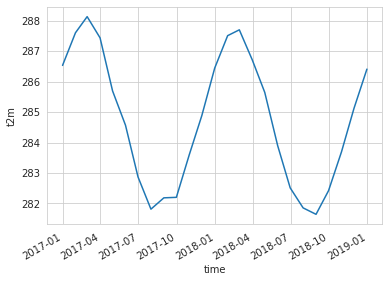

In [35]:
# last x months
t2m.mean(['lat', 'lon']).resample({'time': 'M'}).mean().isel(time=slice(-25, None)).plot();

#### Daily, Monthly, Seasonal Means

In [36]:
t2m_season_mean = t2m.groupby('time.season').mean('time')
t2m_season_std  = t2m.groupby('time.season').std('time')

t2m_month_mean = t2m.groupby('time.month').mean('time')
t2m_month_std  = t2m.groupby('time.month').std('time')

anomalies_month = t2m.groupby('time.month') - t2m_month_mean
anomalies_season = t2m.groupby('time.season') - t2m_season_mean

Monthly Mean Anomalies


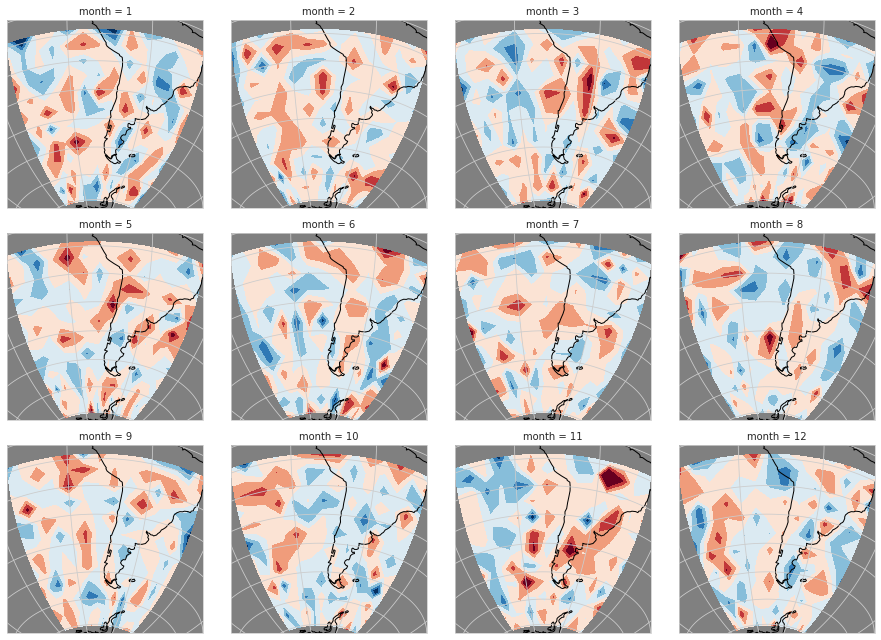

In [37]:
da = anomalies_month.groupby('month').mean(dim=['time']).compute()

title = f'Monthly Mean Anomalies'

faceted_groups_plot(da, 'month', title, save=True)

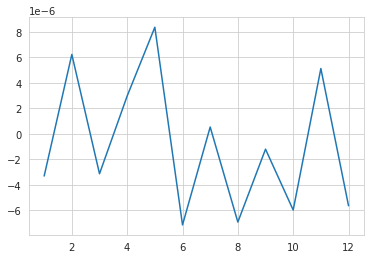

In [38]:
plt.plot(da.month, da.mean(['lat', 'lon']))
plt.show()

Seasonal Mean Anomalies Temp2m


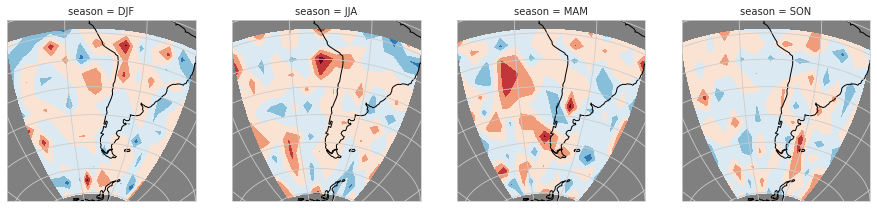

In [39]:
da = anomalies_season.groupby('season').mean(dim=['time']).compute()

title = f'Seasonal Mean Anomalies Temp2m'

faceted_groups_plot(da, 'season', title, save=True)

## TODO: CORRELATION!

## PCA & K-Means?

- TimeSeriesKMeans : tslearn package, http://www.jmlr.org/papers/volume21/20-091/20-091.pdf
- TimeSeries and PCA: Singular spectrum
    http://karthur.org/2017/learning-for-time-series-ssa-vs-pca.html